<h1>Fitting SPI data with 3ML:<br>
    An example</h1>

In [1]:
from pathlib import Path

import numba as nb
import numpy as np
import scipy.stats as stats

from natsort import natsorted

import matplotlib.pyplot as plt


from threeML import *


import warnings
warnings.simplefilter("ignore")

from tqdm.autonotebook import tqdm as tqdm

from astropy.io import fits
import astropy.units as u

import glob,os

[WARNING ] The naima package is not available. Models that depend on it will not be available
[WARNING ] The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it will not be available.
[WARNING ] The ebltable package is not available. Models that depend on it will not be available
[INFO    ] Starting 3ML!
[WARNING ] ROOT minimizer not available
[WARNING ] Multinest minimizer not available
[WARNING ] PyGMO is not available
[WARNING ] The cthreeML package is not installed. You will not be able to use plugins which require the C/C++ interface (currently HAWC)
[WARNING ] Could not import plugin HAWCLike.py. Do you have the relative instrument software installed and configured?
[WARNING ] Could not import plugin FermiLATLike.py. Do you have the relative instrument software installed and configured?
[WARNING ] Env. variable OMP_NUM_THREADS is not set. Please set it to 1 for optimal performances in 3ML
[WARNING ] Env. variable MKL_NUM_THREADS is not set. Please set it t

<h3>Defining the data:</h3>

In [2]:
# analysis object defined by a name, the observation, and the corresponding response
five11 = OGIPLike("five11",
                  observation="spec_tot_511.fits.gz",
                  response="spectral_response.rmf.fits.gz",)

[WARNING ] Found TSTOP and TELAPSE. This file is invalid. Using TSTOP.
[WARNING ] FILTER is not set. This is not a compliant OGIP file. Assuming no FILTER.
[WARNING ] The response is in an extension called MATRIX, which usually means you also need an ancillary file (ARF) which you didn't provide. You should refer to the documentation  of the instrument and make sure you don't need an ARF.
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: gaussian
[INFO    ] - background: None


<h3>Plotting the data</h3>

(0.0, 0.0003220271644143698)

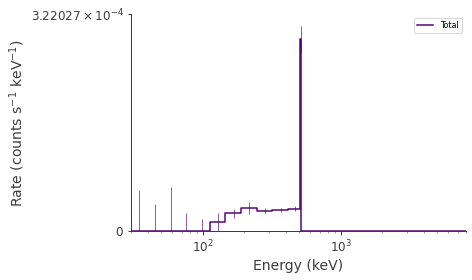

In [3]:
five11.view_count_spectrum();
plt.yscale('symlog')
plt.ylim(0,)

<h3>Beyond 511 keV, there is no data (everything is zero), so select range:</h3>

In [4]:
five11.set_active_measurements('c0-c11')

[INFO    ] Range c0-c11 translates to channels 0-11


(0.0, 0.0004265857278369367)

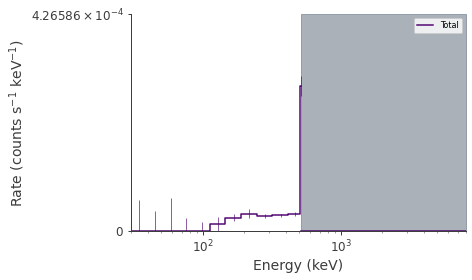

In [5]:
five11.view_count_spectrum();
plt.yscale('symlog')
plt.ylim(0,)

<h3>Grey range is masked out now</h3>

<h3>We want to fit the spectrum with a Positronium model: Ortho-Positronium + 511-keV Line</h3>

<h3>In 3ML you can define arbitrary functions and read it in<br>
    (Have a look at the Posistronium_Spectrum.py! This also takes into account the correct units of your spectral functions and physical parameters!)</h3>

In [6]:
from Positronium_Spectrum import Positronium_Spectrum

In [7]:
Positronium_Spectrum()

* description: Positronium spectrum, define by the ortho-Ps (3-photon decay) and para-Ps
    * (2-photon decay = line) component. Physical bounds are included so that the ortho-Ps
    * spectrum is at most 4.5 times the para-Ps spectrum (maximum allowed by quantum statistics),
    * given by the ratio as a function of the Positronium fraction f_Ps. The flux F is
    * chosen as the line flux as a normalisation of the total spectrum.
  * formula: $ F \times \left[ L(E;\mu,\sigma) + r(f_{\rm Ps}) O(E;\mu) \right] $
  * parameters:
    * Flux:
      * value: 0.001
      * desc: Normalization of flux (chosen to be line flux)
      * min_value: 0.0
      * max_value: 1000.0
      * unit: ''
      * is_normalization: true
      * delta: 0.1
      * free: true
    * mu:
      * value: 511.0
      * desc: centroid of the 511 keV line
      * min_value: 490.0
      * max_value: 530.0
      * unit: ''
      * is_normalization: false
      * delta: 51.1
      * free: false
    * sigma:
      * value: 1.4
      * desc: width of the 511 keV line
      * min_value: 0.81
      * max_value: 20.0
      * unit: ''
      * is_normalization: false
      * delta: 0.13999999999999999
      * free: false
    * f_Ps:
      * value: 1.0
      * desc: Positronium fraction
      * min_value: 0.0
      * max_value: 1.0
      * unit: ''
      * is_normalization: false
      * delta: 0.1
      * free: true

<h3>Now we define a 'source' that we want to fit</h3>

In [8]:
# source means that at a position in Galactic coordinates, for example,
# (which we already cared for), we want to fit a certain spectrum, here
# the Positronium Spectrum
ps_source = PointSource('ps_source',
                        l=0,b=0,
                        spectral_shape=Positronium_Spectrum())

<h3>This completely defines our model:</h3>

In [9]:
ps_model = Model(ps_source)

In [10]:
ps_model.display(complete=True)

Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (2):
--------------------

                  value min_value max_value      unit
ps_source...Flux  0.001       0.0    1000.0  s-1 cm-2
ps_source...f_Ps    1.0       0.0       1.0          

Fixed parameters (4):
---------------------

                      value min_value max_value unit
ps_source.position.l    0.0       0.0     360.0  deg
ps_source.position.b    0.0     -90.0      90.0  deg
ps_source...mu        511.0     490.0     530.0  keV
ps_source...sigma       1.4      0.81      20.0  keV

Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

<h3>Let's see how this model looks like for a given energy range:</h3>

(10, 600)

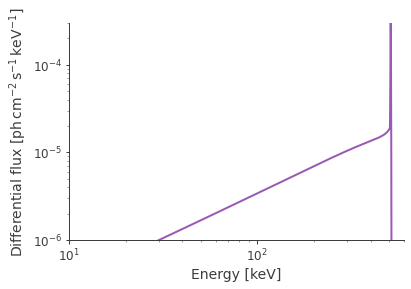

In [11]:
# Set up the energies

energies = np.linspace(0,1e3,10000)

# Get the differential flux

differential_flux = ps_model.ps_source(energies)


fig, ax = plt.subplots()

ax.loglog(energies, differential_flux)

ax.set_xlabel("Energy [keV]")
ax.set_ylabel(r"Differential flux [$\mathrm{ph\,cm^{-2}\,s^{-1}\,keV^{-1}}$]")

ax.set_ylim(1e-6,3e-4)
ax.set_xlim(10,600)

#ax.set_xscale('linear')
#ax.set_yscale('linear')

<h3>And now we try to fit that model to our data, so we define a DataList:</h3>

In [12]:
ps_data = DataList(five11)

<h3>We combine our model and our data in a likelihood object:</h3>

In [13]:
ps_jl = JointLikelihood(ps_model, ps_data)

[INFO    ] set the minimizer to minuit


<h3>And fit:</h3>

In [14]:
best_fit_parameters_ps, likelihood_values_ps = ps_jl.fit()

[WARNING ] 49.88 percent of samples have been thrown away because they failed the constraints on the parameters. This results might not be suitable for error propagation. Enlarge the boundaries until you loose less than 1 percent of the samples.
Best fit values:



,result,unit
parameter,,
ps_source.spectrum.main.Positronium_Spectrum.Flux,(1.64 +/- 0.07) x 10^-3,1 / (cm2 s)
ps_source.spectrum.main.Positronium_Spectrum.f_Ps,(10.00000 +/- 0.00021) x 10^-1,



Correlation matrix:



1.00,-0.00
-0.00,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
five11,16.060689
total,16.060689



Values of statistical measures:



,statistical measures
AIC,37.454712
BIC,37.091192


<h3>Looking at the fit:</h3>

In [15]:
ps_jl.restore_best_fit()

(1e-06, 0.0004209053982070378)

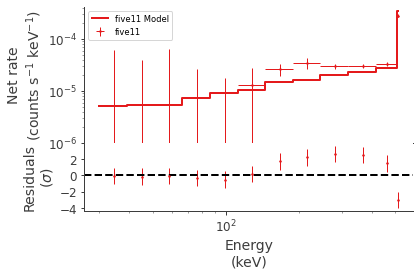

In [16]:
fig = display_spectrum_model_counts(ps_jl,step=True)
fig.axes[0].set_ylim(1e-6)

<h3>Not a very good fit (as expected), because the data in the individual component is not very good.<br><br>
    Let's instead have a look at the total spectrum, with multiple components, and a Bayesian treatment:</h3>

In [17]:
# this new file already includes some measure of systematics
ig_file = "spec_tot_astrobackground_wsys.fits.gz"

In [18]:
ig_data_set = OGIPLike("ig_data",
                       observation=ig_file,
                       response="spectral_response.rmf.fits.gz",)

ig_data_set.set_active_measurements('c0-c24')

[WARNING ] Found TSTOP and TELAPSE. This file is invalid. Using TSTOP.
[WARNING ] FILTER is not set. This is not a compliant OGIP file. Assuming no FILTER.
[WARNING ] The response is in an extension called MATRIX, which usually means you also need an ancillary file (ARF) which you didn't provide. You should refer to the documentation  of the instrument and make sure you don't need an ARF.
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: gaussian
[INFO    ] - background: None
[INFO    ] Range c0-c24 translates to channels 0-24


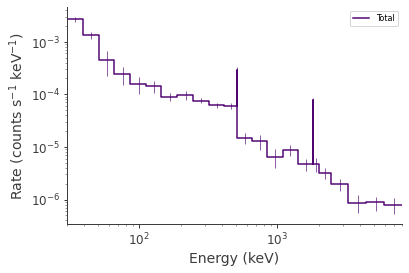

In [19]:
ig_data_set.view_count_spectrum();

<h3>We now define a more complex model:</h3>

In [20]:
# here, I initialise the spectral model to some values to be closer to the real
# this is not needed in general if the priors are used properly
ig_spectrum = Cutoff_powerlaw(K=1e-5,piv=50,index=0,xc=7.) + \
              Powerlaw(K=1e-5,piv=1000,index=-1.3) + \
              Gaussian(F=1e-3,mu=1809,sigma=1.7) + \
              Positronium_Spectrum(Flux=1.7e-3,f_Ps=1.0)

# same as before, but now with new shape
ig_source = PointSource("ig", l=0, b=0, spectral_shape=ig_spectrum)

# same as before but with new 'source'
ig_model = Model(ig_source)

# same as before but with total spectrum
ig_data = DataList(ig_data_set)

# some parameters can be fixed, for example, the index of the cutoff powerlaw (0, from Bouchet+2011)
ig_model.ig.spectrum.main.composite.index_1.fix = True
# or the width and centroid of the 26Al line
ig_model.ig.spectrum.main.composite.mu_3.fix = True
ig_model.ig.spectrum.main.composite.sigma_3.fix = True

# and let's have a look
ig_model.display(complete=True)

Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (7):
--------------------

                                      value min_value max_value  \
ig.spectrum.main.composite.K_1      0.00001       0.0    1000.0   
ig.spectrum.main.composite.xc_1         7.0       1.0      None   
ig.spectrum.main.composite.K_2      0.00001       0.0    1000.0   
ig.spectrum.main.composite.index_2     -1.3     -10.0      10.0   
ig.spectrum.main.composite.F_3        0.001      None      None   
ig.spectrum.main.composite.Flux_4    0.0017       0.0    1000.0   
ig.spectrum.main.composite.f_Ps_4       1.0       0.0       1.0   

                                              unit  
ig.spectrum.main.composite.K_1      keV-1 s-1 cm-2  
ig.spectrum.main.composite.xc_1                keV  
ig.spectrum.main.composite.K_2      keV-1 s-1 cm-2  
ig.spectrum.main.composite.index_2                  
ig.spectrum.main.composite.F_3            s-1 cm-2  
ig.spectrum.main.composite.Flux_4         s-1 cm-2  
ig.spectrum.main.composite.f_Ps_4                   

Fixed parameters (9):
---------------------

                                     value min_value max_value unit
ig.position.l                          0.0       0.0     360.0  deg
ig.position.b                          0.0     -90.0      90.0  deg
ig.spectrum.main.composite.piv_1      50.0      None      None  keV
ig.spectrum.main.composite.index_1     0.0     -10.0      10.0     
ig.spectrum.main.composite.piv_2    1000.0      None      None  keV
ig.spectrum.main.composite.mu_3     1809.0      None      None  keV
ig.spectrum.main.composite.sigma_3     1.7       0.0      None  keV
ig.spectrum.main.composite.mu_4      511.0     490.0     530.0  keV
ig.spectrum.main.composite.sigma_4     1.4      0.81      20.0  keV

Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

<h3>You can always access different model parameters directly (and change them in this way):</h3>

In [21]:
print(ig_model.ig.spectrum.main.composite.F_3)

Parameter F_3 = 0.001 [1 / (cm2 s)]
(min_value = None, max_value = None, delta = 0.1, free = True)


<h3>Let's plot the model as it is now; afterwards we fit:</h3>

(10, 10000)

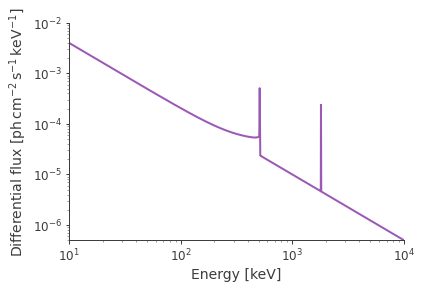

In [22]:
energies = np.linspace(0,1e4,10000)

# Get the differential flux

differential_flux_ig = ig_model.ig(energies)


fig, ax = plt.subplots()

ax.loglog(energies, differential_flux_ig)

ax.set_xlabel("Energy [keV]")
ax.set_ylabel(r"Differential flux [$\mathrm{ph\,cm^{-2}\,s^{-1}\,keV^{-1}}$]")

ax.set_ylim(5e-7,1e-2)
ax.set_xlim(10,10000)

#ax.set_xscale('linear')
#ax.set_yscale('linear')

<h3>Maximum Likelihood Fit:</h3>

In [23]:
ig_jl = JointLikelihood(ig_model, ig_data)

best_fit_parameters_ig, likelihood_values_ig = ig_jl.fit()

[INFO    ] set the minimizer to minuit
[WARNING ] 50.12 percent of samples have been thrown away because they failed the constraints on the parameters. This results might not be suitable for error propagation. Enlarge the boundaries until you loose less than 1 percent of the samples.
Best fit values:



,result,unit
parameter,,
ig.spectrum.main.composite.K_1,(0.7 -0.4 +1.1) x 10^-1,1 / (cm2 keV s)
ig.spectrum.main.composite.xc_1,9.3 -2.0 +2.5,keV
ig.spectrum.main.composite.K_2,(7.0 -0.4 +0.5) x 10^-6,1 / (cm2 keV s)
ig.spectrum.main.composite.index_2,-1.37 +/- 0.05,
ig.spectrum.main.composite.F_3,(4.4 +/- 0.5) x 10^-4,1 / (cm2 s)
ig.spectrum.main.composite.Flux_4,(1.48 +/- 0.14) x 10^-3,1 / (cm2 s)
ig.spectrum.main.composite.f_Ps_4,(10.0000 +/- 0.0007) x 10^-1,



Correlation matrix:



1.00,-0.99,0.06,-0.17,0.00,-0.05,-0.00
-0.99,1.00,-0.07,0.25,-0.00,0.07,0.00
0.06,-0.07,1.00,0.29,-0.05,-0.25,-0.00
-0.17,0.25,0.29,1.00,-0.04,0.14,0.00
0.00,-0.00,-0.05,-0.04,1.00,0.01,0.00
-0.05,0.07,-0.25,0.14,0.01,1.00,-0.00
-0.00,0.00,-0.00,0.00,0.00,-0.00,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
ig_data,9.127872
total,9.127872



Values of statistical measures:



,statistical measures
AIC,39.255745
BIC,40.502122


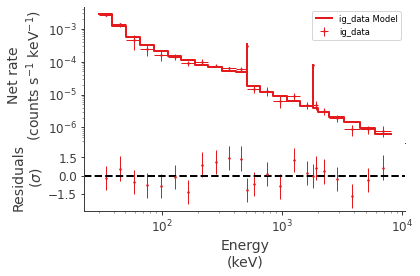

In [24]:
ig_jl.restore_best_fit()
fig = display_spectrum_model_counts(ig_jl,step=True,)

<h3>Not bad: the residuals show barely any structure, and the $\chi^2$ would be -log(likelihood)*2, i.e. 18.2, for 24 data points, and 7 fit parameters (17 dof).</h3>

<h3>And finally a Bayesian fit, i.e. including useful priors to the parameters (for example, positivity of fluxes, known Positronium fraction from previous measurements, or cutoff energy of the CV part, etc.):</h3>

In [25]:
# setting the priors

# CVs
ig_model.ig.spectrum.main.composite.K_1.prior = Log_uniform_prior(lower_bound=1e-5, upper_bound=1e0)
ig_model.ig.spectrum.main.composite.xc_1.prior = Truncated_gaussian(F=1,mu=7,sigma=3,lower_bound=1,upper_bound=100)

# power-law continuum (~ICS)
ig_model.ig.spectrum.main.composite.K_2.prior = Log_uniform_prior(lower_bound=1e-10, upper_bound=1e0)
ig_model.ig.spectrum.main.composite.index_2.prior = Uniform_prior(lower_bound=-3,upper_bound=0)

# 26Al line flux
ig_model.ig.spectrum.main.composite.F_3.prior = Log_uniform_prior(lower_bound=1e-10, upper_bound=1e0)

# positron annihilation
ig_model.ig.spectrum.main.composite.Flux_4.prior = Log_uniform_prior(lower_bound=1e-6, upper_bound=1e-1)
ig_model.ig.spectrum.main.composite.f_Ps_4.prior = Truncated_gaussian(F=1,mu=1,sigma=0.2,lower_bound=0,upper_bound=1)

In [26]:
ig_bs = BayesianAnalysis(ig_model, ig_data)
ig_bs.set_sampler("emcee")
ig_bs.sampler.setup(n_iterations=2000,n_burn_in=5000,n_walkers=20)
ig_samples = ig_bs.sample(quiet=False)

[WARNING ] External parameter cons_ig_data already exist in the model. Overwriting it...
[INFO    ] sampler set to emcee


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

[INFO    ] Mean acceptance fraction: 0.32194999999999996
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
ig.spectrum.main.composite.K_1,(2.2 -1.6 +2.0) x 10^-1,1 / (cm2 keV s)
ig.spectrum.main.composite.xc_1,8.1 -1.8 +1.6,keV
ig.spectrum.main.composite.K_2,(7.1 +/- 0.5) x 10^-6,1 / (cm2 keV s)
ig.spectrum.main.composite.index_2,-1.37 -0.04 +0.05,
ig.spectrum.main.composite.F_3,(4.4 -0.5 +0.4) x 10^-4,1 / (cm2 s)
ig.spectrum.main.composite.Flux_4,(1.49 +/- 0.15) x 10^-3,1 / (cm2 s)
ig.spectrum.main.composite.f_Ps_4,(9.73 -0.21 +0.23) x 10^-1,



Values of -log(posterior) at the minimum:



,-log(posterior)
ig_data,2.599647
total,2.599647



Values of statistical measures:



,statistical measures
AIC,15.800706
BIC,17.047083
DIC,-15.158310
PDIC,-18.164833


<h3>Corner plot for parameter posteriors:</h3>

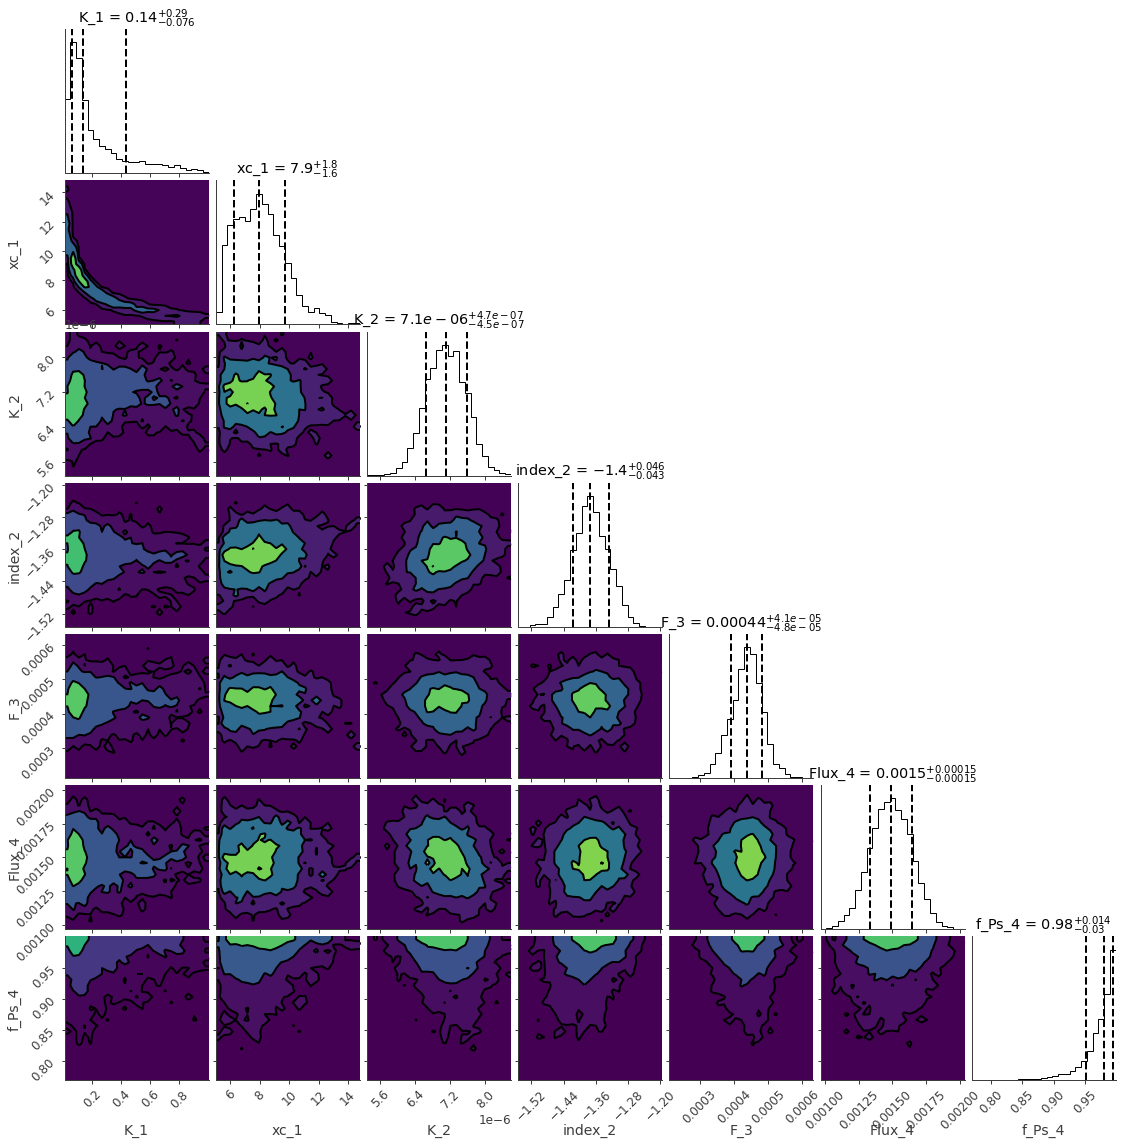

In [27]:
sigma = 68.3
ig_bs.results.corner_plot(
                    #truths=np.array([1,2,3,4]),
                    quantiles=(50+sigma/np.array([-2,np.inf,+2]))/100.,
                    #quantiles=(0.16, 0.50, 0.84),
                    show_titles=True,
                    bins=25,
                    fill_contours=True,
                    contourf_kwargs={"cmap": plt.cm.viridis, "colors":None},
                    levels=[1-np.exp(-4.5),1-np.exp(-2.0),1-np.exp(-0.5)],
                    truth_color='orange');

<h3>This is your result: values and uncertainties.<br><br>
    For upper bounds, see below.</h3>

<h3>Plotting the model components in model and data space:</h3>

In [28]:
# getting the samples
ig_bs_samples = ig_bs.results.samples

In [29]:
# energies and bin widths
ee = 0.5*(ig_data_set.energy_boundaries[1] + ig_data_set.energy_boundaries[0])
dee = np.diff(ig_data_set.energy_boundaries,axis=0)[0]

In [30]:
# looping over the samples to create model posteriors

# use 10000 samples in total (can be changed to make faster)
n_use = 10000

# model evaluation at 1000 points logarithmically spaced between 30 and 8000 keV
N_model = 1000
x_model = np.logspace(np.log10(30),np.log10(8000),N_model)

# arrays for model space
y_models_total = np.zeros((N_model,n_use))
y_models_cutoff = np.zeros((N_model,n_use))
y_models_powerlaw = np.zeros((N_model,n_use))
y_models_gaussian = np.zeros((N_model,n_use))
y_models_positron = np.zeros((N_model,n_use))

# arrays for data space
d_models_total = np.zeros((24,n_use))
d_models_cutoff = np.zeros((24,n_use))
d_models_powerlaw = np.zeros((24,n_use))
d_models_gaussian = np.zeros((24,n_use))
d_models_positron = np.zeros((24,n_use))


# and looping
for i in tqdm(range(n_use)):
    
    # cutoff powerlaw part
    cutoff_spec   = Cutoff_powerlaw(K=ig_bs_samples[0,i],piv=50,index=0,xc=ig_bs_samples[1,i])
    y_models_cutoff[:,i] = cutoff_spec.fast_call(x_model)
    tmp_source_cutoff = PointSource("tmp_cutoff", l=0, b=0, spectral_shape=cutoff_spec)
    tmp_model_cutoff = Model(tmp_source_cutoff)
    ig_data_set.set_model(tmp_model_cutoff)
    cutoff_d = ig_data_set.expected_model_rate
    d_models_cutoff[:,i] = cutoff_d/dee
    
    
    # powerlaw part
    powerlaw_spec = Powerlaw(K=ig_bs_samples[2,i],piv=1000,index=ig_bs_samples[3,i])
    y_models_powerlaw[:,i] = powerlaw_spec.fast_call(x_model)
    tmp_source_powerlaw = PointSource("tmp_powerlaw", l=0, b=0, spectral_shape=powerlaw_spec)
    tmp_model_powerlaw = Model(tmp_source_powerlaw)
    ig_data_set.set_model(tmp_model_powerlaw)
    powerlaw_d = ig_data_set.expected_model_rate
    d_models_powerlaw[:,i] = powerlaw_d/dee
    
    
    # 26Al line part
    gaussian_spec = Gaussian(F=ig_bs_samples[4,i],mu=1809,sigma=1.7)
    y_models_gaussian[:,i] = gaussian_spec.fast_call(x_model)
    tmp_source_gaussian = PointSource("tmp_gaussian", l=0, b=0, spectral_shape=gaussian_spec)
    tmp_model_gaussian = Model(tmp_source_gaussian)
    ig_data_set.set_model(tmp_model_gaussian)
    gaussian_d = ig_data_set.expected_model_rate
    d_models_gaussian[:,i] = gaussian_d/dee
    
    
    # positronium part
    positron_spec = Positronium_Spectrum(Flux=ig_bs_samples[5,i],f_Ps=ig_bs_samples[6,i])
    y_models_positron[:,i] = positron_spec.fast_call(x_model)
    tmp_source_positron = PointSource("tmp_positron", l=0, b=0, spectral_shape=positron_spec)
    tmp_model_positron = Model(tmp_source_positron)
    ig_data_set.set_model(tmp_model_positron)
    positron_d = ig_data_set.expected_model_rate
    d_models_positron[:,i] = positron_d/dee
    
    
    # total spec
    total_spec = cutoff_spec+powerlaw_spec+gaussian_spec+positron_spec
    y_models_total[:,i] = total_spec.fast_call(x_model)
    tmp_source = PointSource("tmp", l=0, b=0, spectral_shape=total_spec)
    tmp_model = Model(tmp_source)
    ig_data_set.set_model(tmp_model)
    total_d = ig_data_set.expected_model_rate
    d_models_total[:,i] = total_d/dee

  0%|          | 0/10000 [00:00<?, ?it/s]

<h3>Model space smooth models / how reality would look like:</h3>

Text(0.5, 0, 'Energy [keV]')

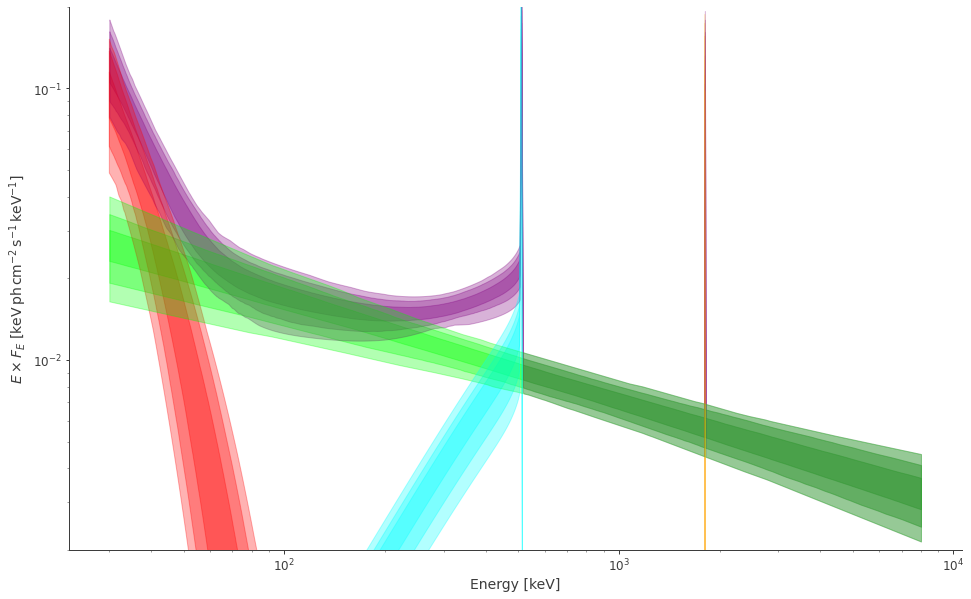

In [31]:
edx = 1


plt.figure(figsize=(16,10))

levels = [68.3,95.4,99.7]

for level in levels:

    plt.fill_between(x_model,
                    np.percentile(y_models_total,50+level/2,axis=1)*x_model**edx,
                    np.percentile(y_models_total,50-level/2,axis=1)*x_model**edx,
                    color='purple',alpha=0.3)
    
    plt.fill_between(x_model,
                    np.percentile(y_models_cutoff,50+level/2,axis=1)*x_model**edx,
                    np.percentile(y_models_cutoff,50-level/2,axis=1)*x_model**edx,
                    color='red',alpha=0.3)
    
    plt.fill_between(x_model,
                    np.percentile(y_models_powerlaw,50+level/2,axis=1)*x_model**edx,
                    np.percentile(y_models_powerlaw,50-level/2,axis=1)*x_model**edx,
                    color='lime',alpha=0.3)
    
    plt.fill_between(x_model,
                    np.percentile(y_models_gaussian,50+level/2,axis=1)*x_model**edx,
                    np.percentile(y_models_gaussian,50-level/2,axis=1)*x_model**edx,
                    color='orange',alpha=0.3)

    plt.fill_between(x_model,
                    np.percentile(y_models_positron,50+level/2,axis=1)*x_model**edx,
                    np.percentile(y_models_positron,50-level/2,axis=1)*x_model**edx,
                    color='cyan',alpha=0.3)

    
plt.xscale('log')
plt.yscale('log')

if edx == 2:
    plt.ylim(2e-1,5e2)
    plt.ylabel(r'$E^2 \times F_E$ [$\mathrm{keV^2\,ph\,cm^{-2}\,s^{-1}\,keV^{-1}}$]')
elif edx == 1:
    plt.ylim(2e-3,2e-1)
    plt.ylabel(r'$E \times F_E$ [$\mathrm{keV\,ph\,cm^{-2}\,s^{-1}\,keV^{-1}}$]')
else:
    plt.ylim(6e-7,1e-2)
    plt.ylabel(r'$F_E$ [$\mathrm{ph\,cm^{-2}\,s^{-1}\,keV^{-1}}$]')
    
plt.xlabel('Energy [keV]')

<h3>Data space / how the models are seen by the instrument (with residuals):</h3>

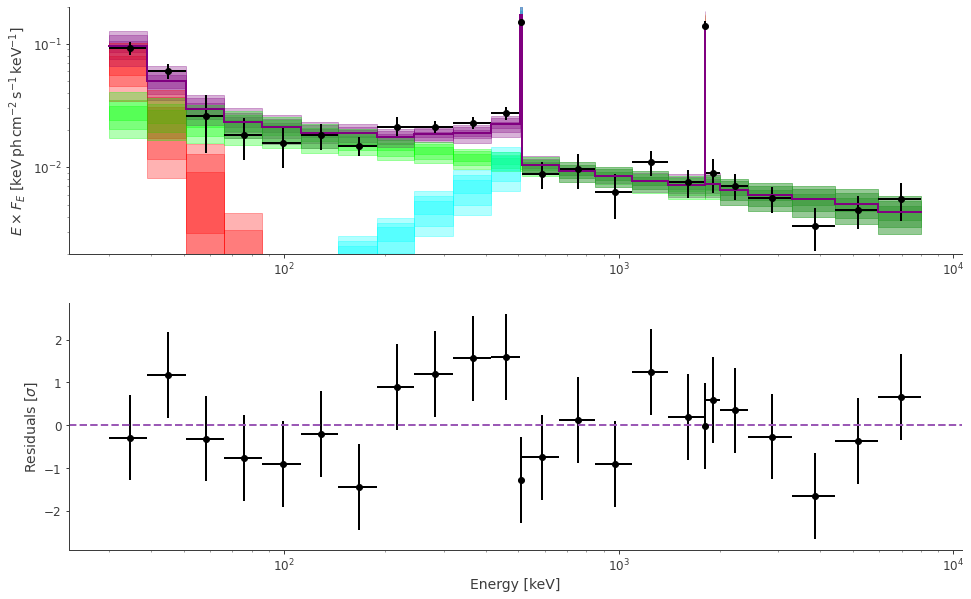

In [32]:
edx = 1

plt.figure(figsize=(16,10))

plt.subplot(211)
for level in levels:
    
    for i in range(len(ee)):
        
        plt.fill_between([ee[i]-dee[i]/2,ee[i]+dee[i]/2],
                         np.repeat(np.percentile(d_models_total[i,:],50+level/2),2)*ee[i]**edx,
                         np.repeat(np.percentile(d_models_total[i,:],50-level/2),2)*ee[i]**edx,
                         color='purple',alpha=0.3,step='mid')
        
        plt.fill_between([ee[i]-dee[i]/2,ee[i]+dee[i]/2],
                         np.repeat(np.percentile(d_models_cutoff[i,:],50+level/2),2)*ee[i]**edx,
                         np.repeat(np.percentile(d_models_cutoff[i,:],50-level/2),2)*ee[i]**edx,
                         color='red',alpha=0.3,step='mid')
            
        plt.fill_between([ee[i]-dee[i]/2,ee[i]+dee[i]/2],
                         np.repeat(np.percentile(d_models_powerlaw[i,:],50+level/2),2)*ee[i]**edx,
                         np.repeat(np.percentile(d_models_powerlaw[i,:],50-level/2),2)*ee[i]**edx,
                         color='lime',alpha=0.3,step='mid')
                
        plt.fill_between([ee[i]-dee[i]/2,ee[i]+dee[i]/2],
                         np.repeat(np.percentile(d_models_gaussian[i,:],50+level/2),2)*ee[i]**edx,
                         np.repeat(np.percentile(d_models_gaussian[i,:],50-level/2),2)*ee[i]**edx,
                         color='orange',alpha=0.3,step='mid')
                    
        plt.fill_between([ee[i]-dee[i]/2,ee[i]+dee[i]/2],
                         np.repeat(np.percentile(d_models_positron[i,:],50+level/2),2)*ee[i]**edx,
                         np.repeat(np.percentile(d_models_positron[i,:],50-level/2),2)*ee[i]**edx,
                         color='cyan',alpha=0.3,step='mid')
   
        plt.plot([ee[i]-dee[i]/2,ee[i]+dee[i]/2],
                  np.repeat(np.percentile(d_models_total[i,:],50),2)*ee[i]**edx,
                       linewidth=2,color='purple')
        if i != 23:
                plt.plot([ee[i]+dee[i]/2,ee[i+1]-dee[i+1]/2],
                           [np.percentile(d_models_total[i,:],50)*ee[i]**edx,
                            np.percentile(d_models_total[i+1,:],50)*ee[i+1]**edx],
                           linewidth=2,color='purple')


plt.errorbar(ee,ig_data_set.source_rate/dee*ee**edx,
                     xerr=dee/2,yerr=ig_data_set.source_rate_error/dee*ee**edx,
                     linestyle='',marker='o',color='black')

plt.xscale('log')
plt.yscale('log')
if edx == 2:
    plt.ylim(2e-1,5e2)
    plt.ylabel(r'$E^2 \times F_E$ [$\mathrm{keV^2\,ph\,cm^{-2}\,s^{-1}\,keV^{-1}}$]')
elif edx == 1:
    plt.ylim(2e-3,2e-1)
    plt.ylabel(r'$E \times F_E$ [$\mathrm{keV\,ph\,cm^{-2}\,s^{-1}\,keV^{-1}}$]')
else:
    plt.ylim(6e-7,1e-2)
    plt.ylabel(r'$F_E$ [$\mathrm{ph\,cm^{-2}\,s^{-1}\,keV^{-1}}$]')
    
plt.subplot(212)

plt.errorbar(ee,(ig_data_set.source_rate/dee-np.percentile(d_models_total,50,axis=1))/(ig_data_set.source_rate_error/dee),
                     xerr=dee/2,yerr=np.repeat(1,24),
                     linestyle='',marker='o',color='black')
plt.ylabel(r'Residuals [$\sigma$]')

plt.xscale('log')
plt.xlabel('Energy [keV]')

#plt.yscale('log')

plt.axhline(0,linestyle='--')

<h1>Determining upper bounds on parameters with a table model</h1>

<h3>In the following, I will use the PBH spectrum, and want to determine the amount of Inverse Compton scattering (table model from GALPROP) that I can hide in that spectrum.<br><br>
    That means we first define a table model, and the try to fit it to the PBH spectrum.</h3>

<h3>Defining a table model in 3ML:</h3>

In [33]:
# where the spectra are (from Joanna's file)
ic_dir =  '../ics_template/ics_spectra/'

In [34]:
# making a list of the files
ic_files = []
for dirpath, subdirs, files in os.walk(ic_dir):
    for file in files:
        if glob.fnmatch.fnmatch(file,'ics_spectrum_el_norm_*_g0_-*.csv'):
            ic_files.append(os.path.join(dirpath, file))
            
ic_files.sort()
ic_files = np.array(ic_files)

In [35]:
# sorting to ascending parameters
ic_files = ic_files.reshape((3,11))
ic_files = np.flip(ic_files,axis=1)

<h3>Reading in one file to see how it looks like:</h3>

In [36]:
df_ics = pd.read_csv(ic_files[1,0])

In [37]:
df_ics

,# Energy [keV],Spectrum [ph/cm^2/s/keV]
0,500.000,5.978000e-05
1,509.000,5.804000e-05
2,518.162,5.633000e-05
3,527.489,5.462000e-05
4,536.984,5.293000e-05
...,...,...
226,28181.742,3.091000e-08
227,28689.013,2.962000e-08
228,29205.415,2.842000e-08
229,29731.113,2.728000e-08


In [38]:
# that would define energies and fluxes
e_ics = df_ics['# Energy [keV]'].values
f_ics = df_ics[' Spectrum [ph/cm^2/s/keV]'].values

In [39]:
# define the name, energies, and parameters of the model, and out it is interpolated
from astromodels import TemplateModelFactory

tmf = TemplateModelFactory(
    "ics_template", "ics_template_test", e_ics*u.keV, ["A","p"],spline_smoothing_factor=3,interpolation_degree=2,
)

In [40]:
# parameters
A_arr = np.array([0.1,1,10])
p_arr = np.linspace(-2.3,-1.3,11)

# add parameter definition to the table model
tmf.define_parameter_grid("A",A_arr)
tmf.define_parameter_grid("p",p_arr)

In [41]:
# calculate (add) model to factory
for a_idx in range(len(A_arr)):
    for p_idx in range(len(p_arr)):
        df_ics_tmp = pd.read_csv(ic_files[a_idx,p_idx])
        f_ics_tmp = df_ics_tmp[' Spectrum [ph/cm^2/s/keV]'].values
        tmf.add_interpolation_data(f_ics_tmp,A=A_arr[a_idx],p=p_arr[p_idx],)

In [42]:
# save model
tmf.save_data(overwrite=True)

from astromodels import TemplateModel

# load saved model
reloaded_table_model = TemplateModel("ics_template")

<h3>How the model is now defined: similar to other models, but with two additional default parameters, $K$ (amplitude) and $scale$ ((red)-shift).<br><br>
    I <emph>choose</emph> to determine $K$ and $p$, i.e. I fix $A$ and $scale$. This is only for this example.<br><br>
    These considerations must be adapted for other cases (like PBH fraction, etc.)</h3>

In [43]:
reloaded_table_model

* description: ics_template_test
  * formula: n.a.
  * parameters:
    * K:
      * value: 1.0
      * desc: None
      * min_value: null
      * max_value: null
      * unit: ''
      * is_normalization: false
      * delta: 0.1
      * free: true
    * scale:
      * value: 1.0
      * desc: None
      * min_value: null
      * max_value: null
      * unit: ''
      * is_normalization: false
      * delta: 0.1
      * free: true
    * A:
      * value: 1.0
      * desc: None
      * min_value: 0.1
      * max_value: 10.0
      * unit: ''
      * is_normalization: false
      * delta: 0.1
      * free: true
    * p:
      * value: -1.7999999999999998
      * desc: None
      * min_value: -2.3
      * max_value: -1.3
      * unit: ''
      * is_normalization: false
      * delta: 0.18
      * free: true

In [44]:
reloaded_table_model.A.fix=True
reloaded_table_model.scale.fix=True

<h3>And again defining model and data:</h3>

[WARNING ] Found TSTOP and TELAPSE. This file is invalid. Using TSTOP.
[WARNING ] FILTER is not set. This is not a compliant OGIP file. Assuming no FILTER.
[WARNING ] The response is in an extension called MATRIX, which usually means you also need an ancillary file (ARF) which you didn't provide. You should refer to the documentation  of the instrument and make sure you don't need an ARF.
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: gaussian
[INFO    ] - background: None


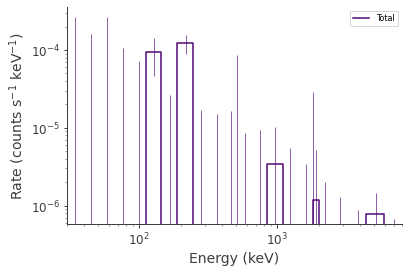

In [45]:
# data
pbh_data_set = OGIPLike("pbh_data",
                       observation='spec_tot_NFW.fits.gz',
                       response="spectral_response.rmf.fits.gz",)

pbh_data_set.view_count_spectrum();
pbh_data = DataList(pbh_data_set)

<h3>(NB: the PBH spectrum does <emph>not</emph> include systematics, yet.)</h3>

In [46]:
# model

# priors
reloaded_table_model.K.prior = Log_uniform_prior(lower_bound=1e-10, upper_bound=10)
reloaded_table_model.p.prior = Uniform_prior(lower_bound=-2.3, upper_bound=-1.3)

# source
pbh_source = PointSource("ps", l=0, b=0, spectral_shape=reloaded_table_model)
pbh_model = Model(pbh_source)

# analysis objects
pbh_bs = BayesianAnalysis(pbh_model, pbh_data)
pbh_bs.set_sampler("emcee")
pbh_bs.sampler.setup(n_iterations=2000,n_burn_in=5000,n_walkers=20)
pbh_samples = pbh_bs.sample(quiet=False)

[INFO    ] sampler set to emcee


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

[INFO    ] Mean acceptance fraction: 0.60775
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
ps.spectrum.main.ics_template.K,(4 +/- 4) x 10^-1,1 / (cm2 keV s)
ps.spectrum.main.ics_template.p,-1.69 -0.30 +0.29,



Values of -log(posterior) at the minimum:



,-log(posterior)
pbh_data,-5.714565
total,-5.714565



Values of statistical measures:



,statistical measures
AIC,16.000560
BIC,17.785239
DIC,17.454288
PDIC,0.158013


<h3>Fitting table models takes significantly longer than analytic functions. So if you know it analytically, use that.</h3>

<h3>What we see already here is: $K$ (the amplitude of the whole thing), is consistent with zero $0.4 \pm 0.4$. This is good, because our spectrum is very much zero. The uncertainties are now determined by how large the error bars of the data points are, and what $p$ actually is. Since the error bars grow larger as we go down in energy, $p$ is probably more like to be smaller (less steep).<br>
We have a look at the corner plot to convince ourselves:</h3>

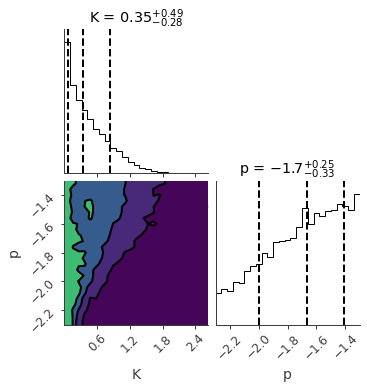

In [47]:
pbh_bs.results.corner_plot(
                    #truths=np.array([1,2,3,4]),
                    quantiles=(50+sigma/np.array([-2,np.inf,+2]))/100.,
                    #quantiles=(0.16, 0.50, 0.84),
                    show_titles=True,
                    bins=25,
                    fill_contours=True,
                    contourf_kwargs={"cmap": plt.cm.viridis, "colors":None},
                    levels=[1-np.exp(-4.5),1-np.exp(-2.0),1-np.exp(-0.5)],
                    truth_color='orange');

<h3>Now with the samples that we drew to try and fit the spectrum that is consistent with zero, we can do two things: 1) determine the upper bound on $K$, given <emph>all</emph> possible values of $p$ (in our grid), and 2) determine the upper bounds on $K$ given <emph>any</emph> value of $p$, i.e. we determine $K(p)$:</h3>

In [48]:
# the samples
pbh_bs_samples = pbh_bs.results.samples
pbh_bs_samples.shape

(2, 40000)

<h3>Case 1: global upper bound on $K$.<br><br>
    What we formally do with the next one-liner is solving this integral equation for $K_{\rm ub}$:<br>
    $\int_{0}^{K_{\rm ub}}\,dK\,\int_{p_{\rm min}}^{p_{\rm max}}\,dp\,P(K,p|d) = 1-\alpha$

In [49]:
K_ub = np.percentile(pbh_bs_samples[0,:],99.85)
print('Upper bound on amplitude K (99.85th percentile, i.e. 3sigma): {0:1.2f}'.format(K_ub))

Upper bound on amplitude K (99.85th percentile, i.e. 3sigma): 2.03


<h3>Case 2: local upper bound on $K$, i.e. $K(p)$ (that's basically given by the last contour line in corner plot).<br><br>
    Formally, we solve this integral equation for 'all' values of $p$:<br>
    $\int_{0}^{K_{\rm ub}(\hat{p})}\,dK\,P(K,p=\hat{p}|d) = 1-\alpha$

<h3>There are two equivalent possibilities to do this, looping over values of $p$, or estimating the kernel density of the scatter plot of the samples:</h3>

In [50]:
from scipy import stats
from scipy.ndimage import gaussian_filter1d as smooth

In [51]:
# 3sigma upper bound
alpha = 0.0015

In [52]:
# Kernel Density Estimator (KDE)

# values to evaluate at
N_p = 50
p_edges = np.linspace(-2.3,-1.3,N_p+1)
p_arr = 0.5*(p_edges[1:]+p_edges[0:-1])

N_K = 50
K_edges = np.linspace(0,2.5,N_K+1)
K_arr = 0.5*(K_edges[1:]+K_edges[0:-1])

pp,KK = np.meshgrid(p_arr,K_arr)
positions = np.vstack([KK.ravel(), pp.ravel()])

In [53]:
# estimator and kernel function
kernel = stats.gaussian_kde(pbh_bs_samples)
f = np.reshape(kernel(positions).T, pp.shape)
# normalisation
f = f/np.sum(f*np.diff(p_edges)[0]*np.diff(K_edges)[0])

In [54]:
# loop over p

K_ub_p = np.zeros(N_p)
for i in range(N_p):
    pdx = np.where((pbh_bs_samples[1,:] >= p_edges[i]) & (pbh_bs_samples[1,:] <= p_edges[i+1]))[0]
    K_ub_p[i] = np.percentile(pbh_bs_samples[0,pdx],100*(1-alpha))

<h3>And plotting the equivalent results:</h3>

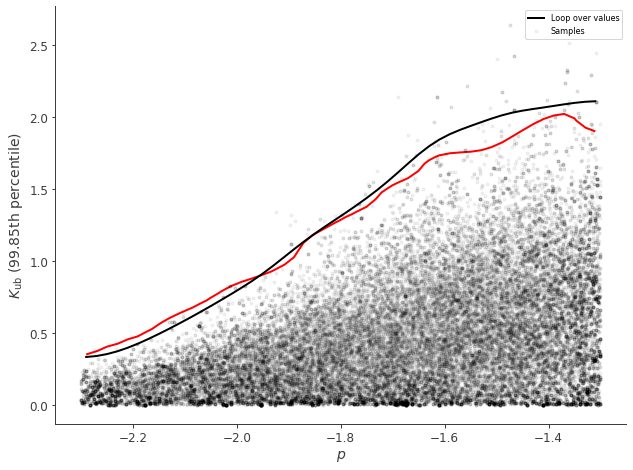

In [55]:
plt.figure(figsize=(10.24,7.68))

plt.plot(p_arr,smooth(K_ub_p,3),color='black',label='Loop over values')

plt.plot(pbh_bs_samples[1,:],pbh_bs_samples[0,:],'k.',alpha=0.05,label='Samples')

plt.contour(p_arr,K_arr,f,levels=[np.sqrt(alpha)],colors='red',label='KDE')

plt.xlabel(r'$p$')
plt.ylabel(r'$K_{\rm ub}$ (99.85th percentile)')

plt.legend()

<h3>We see that how the black and red line relate to the samples. This would be similar to the 'exclusion plot' that you are looking for when doing the PBH model as a function of PBH mass.<br><br>
    I hope this makes it clearer what has to be done now.</h3>